# EDMD and NNDMD for a simple linear system


In this tutorial, we use EDMD to learn approximate Koopman eigenfunctions for the
following two-dimensional, linear system (example from [Rowley, Williams & Kevrekidis,
 _"IPAM MTWS4"_, 2014](http://helper.ipam.ucla.edu/publications/mtws4/mtws4_12328.pdf)):

$$
{\bf x}_{k+1} = \begin{bmatrix} 0.8 & -0.05\\ 0 & 0.7\end{bmatrix}{\bf x}_k,
$$
where ${\bf x} = [x, y]^T$. Polynomial functions $x^iy^j$ with $i,j\in [0,3]$ up to
order 3 are used as basis functions. The true eigenfunctions and eigenvalues can be
approximated as follows:
$$
\varphi_{ij}(x,y) \approx (0.894x - 0.447y)^i y^j\quad \text{for}\quad i,
j\in\mathbb{N}\\
\lambda_{ij} = (0.8)^i(0.7)^j
$$

In [1]:
import sys
sys.path.append('../src')

In [2]:
import pykoopman as pk
from pykoopman.common import Linear2Ddynamics
import scipy
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Collect training data

In [3]:
# Create instance of the dynamical system
sys = Linear2Ddynamics()

# Collect training data
n_pts = 51
n_int = 1
xx, yy = np.meshgrid(np.linspace(-1, 1, n_pts), np.linspace(-1, 1, n_pts))
x = np.vstack((xx.flatten(), yy.flatten()))
n_traj = x.shape[1]

X, Y = sys.collect_data(x, n_int, n_traj)

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$x_1$')]

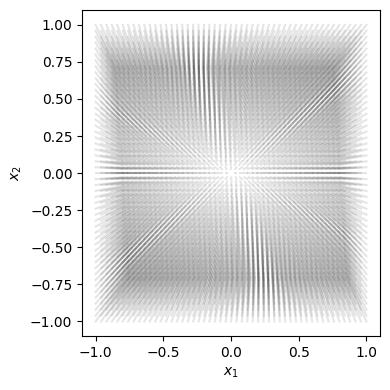

In [4]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4, 4))
for traj_idx in range(n_traj):
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]], '-k',alpha=0.1)
axs.set(ylabel=r'$x_2$',
        xlabel=r'$x_1$')

## Analytic Koopman eigenvalues and eigenfunctions

[1.     0.8    0.7    0.64   0.56   0.512  0.49   0.448  0.392  0.3584
 0.343  0.2744]


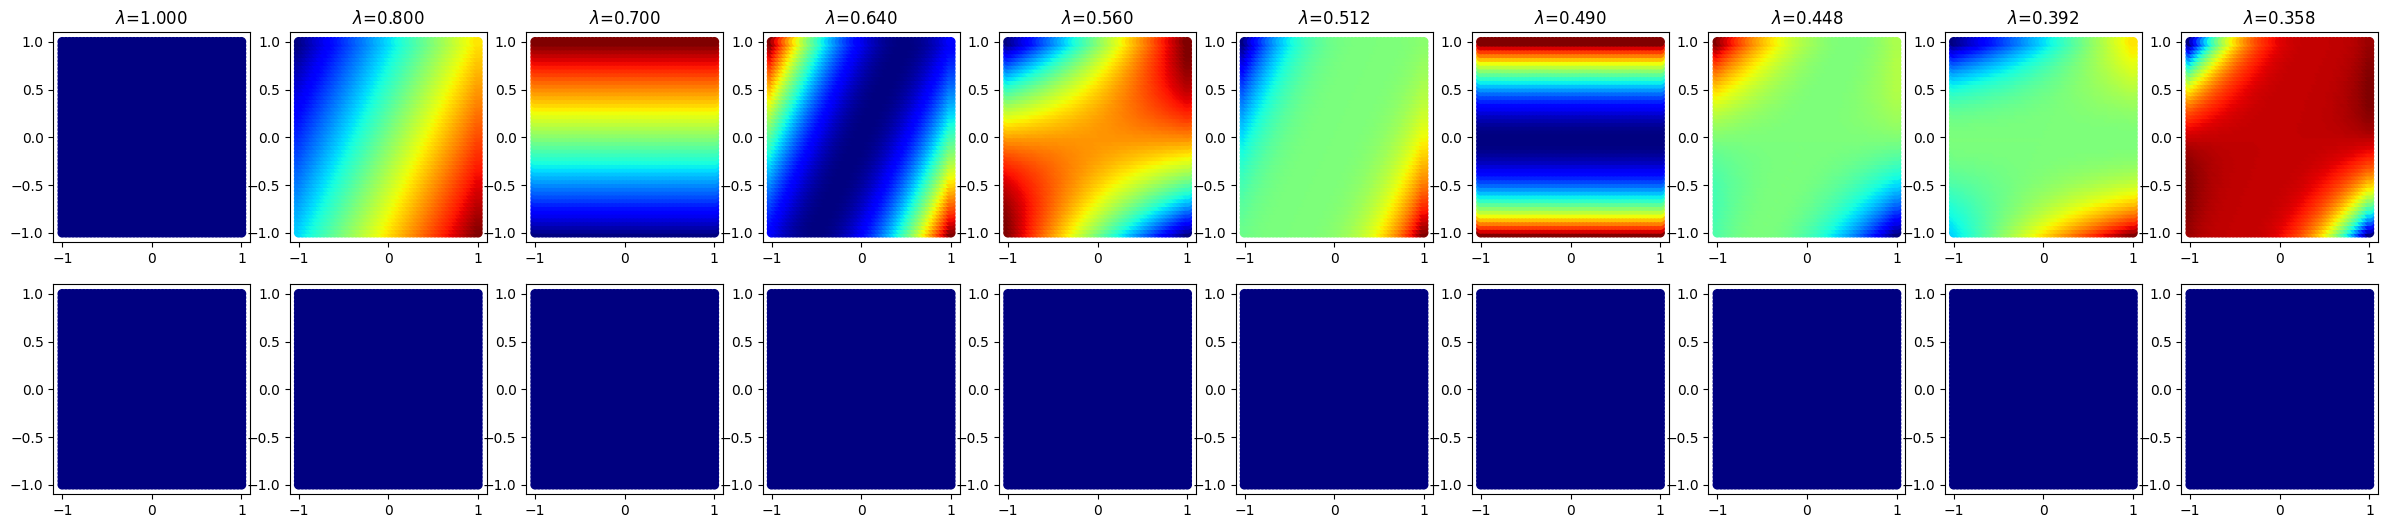

In [5]:
degree = 3
true_efuns = np.zeros((X.shape[1], 12))
true_evals = np.zeros(12)
counter = 0
for i in range(degree+1):
    for j in range(degree+1):
        if i*j <= degree:
            true_evals[counter] = (0.8**i) * (0.7**j)
            # tmp = ((0.894 * xx - 0.447 * yy)**i) * (yy**j)
            # true_efuns[:, counter] = tmp.flatten()
            true_efuns[:, counter] = ((0.894 * x[0, :] - 0.447 * x[1, :])**i) * \
                                     (x[1, :]**j)
            counter += 1

sort_idx = np.argsort(true_evals)
sort_idx = sort_idx[::-1]
true_evals = true_evals[sort_idx]
true_efuns = true_efuns[:, sort_idx]
sys.visualize_modes(X, true_efuns, eigvals=true_evals)
print(true_evals)

## Data-driven approximation with EDMD and polynomial basis functions

[1.    0.8   0.7   0.64  0.56  0.512 0.49  0.448 0.392 0.343]


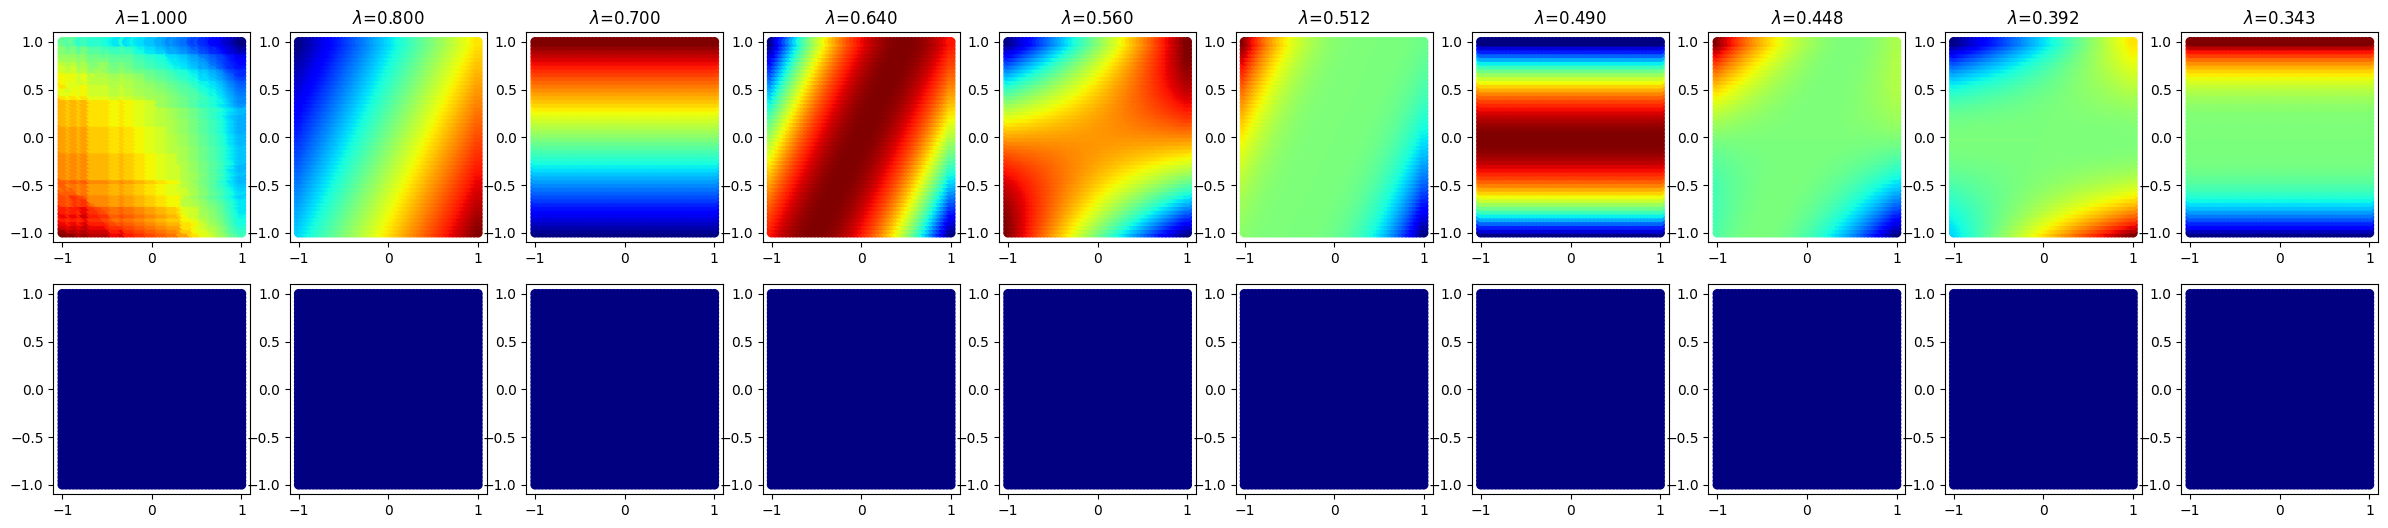

In [6]:
EDMDc = pk.regression.EDMD()
obsv = pk.observables.Polynomial(degree=3)
model = pk.Koopman(observables=obsv, regressor=EDMDc)
model.fit(X.T, y=Y.T)

psi = model.psi(x_col=x)
eigenvalues = np.real(np.diag(model.lamda))
order = np.argsort(eigenvalues)[::-1]

print(eigenvalues[order])
sys.visualize_modes(X, psi.T, eigvals=eigenvalues, order=order)

## Data-driven approximation with NN-DMD

In [7]:
import lightning as L
class IncrementalSequenceLoss(L.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        max_look_forward = pl_module.look_forward
        if trainer.callback_metrics["loss"] < 1e-2 and \
                pl_module.masked_loss_metric.max_look_forward < max_look_forward:
            print("increase width size from {} to {}".format(
                pl_module.masked_loss_metric.max_look_forward,
                pl_module.masked_loss_metric.max_look_forward+1) )
            print("")
            pl_module.masked_loss_metric.max_look_forward += 1

look_forward = 1
dlk_regressor = pk.regression.NNDMD(look_forward=look_forward, 
            config_encoder=dict(input_size=2, hidden_sizes=[32] * 2, output_size=2,
                                activations="linear"),
            config_decoder=dict(input_size=2, hidden_sizes=[32] * 2, output_size=2,
                                activations="linear"),
                                    batch_size=512, lbfgs=True, \
                                    normalize=True, normalize_mode='max',
                                    trainer_kwargs=dict(max_epochs=3, callbacks=[
        IncrementalSequenceLoss()]))

model = pk.Koopman(regressor=dlk_regressor)
model.fit(X.T, Y.T)

INFO: GPU available: True (cuda), used: True
[rank_zero.py:64 -                _info() ] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[rank_zero.py:64 -                _info() ] TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[rank_zero.py:64 -                _info() ] IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[rank_zero.py:64 -                _info() ] HPU available: False, using: 0 HPUs
D:\work\pykoopman\venv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
[rank_zero.py:64 -                _info() ] `Trainer.fit` stopped: `max_epochs=3` reached.


Koopman(observables=Identity(),
        regressor=NNDMD(batch_size=512,
                        config_decoder={'activations': 'linear',
                                        'hidden_sizes': [32, 32],
                                        'input_size': 2, 'output_size': 2},
                        config_encoder={'activations': 'linear',
                                        'hidden_sizes': [32, 32],
                                        'input_size': 2, 'output_size': 2},
                        lbfgs=True, normalize_mode='max',
                        trainer_kwargs={'callbacks': [<__main__.IncrementalSequenceLoss object at 0x000002CC1356A410>],
                                        'max_epochs': 3}))

[0.79999924 0.70000166]


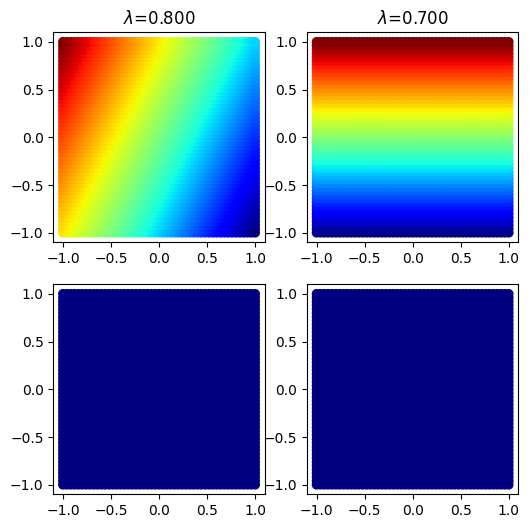

In [8]:
psi = model.psi(x_col=x)
eigenvalues = np.real(np.diag(model.lamda))
order = np.argsort(eigenvalues)[::-1]

print(eigenvalues[order])
sys.visualize_modes(X, psi.T, eigvals=eigenvalues, order=order)

## Check shape of matrices related to Koopman operator

In [9]:
model.A.shape

(2, 2)

In [10]:
model.C.shape

(2, 2)

In [11]:
model.W.shape

(2, 2)

In [12]:
model.lamda.shape

(2, 2)